
# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов.  
В нём можно будет узнать рыночную стоимость своего автомобиля.   
Постройте модель, которая умеет её определять.  
В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.  
Критерии, которые важны заказчику:  
качество предсказания;  
время обучения модели;  
время предсказания модели.  

## Описание данных

### Признаки  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач    
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
### Целевой признак  
Price — цена (евро)  

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split,cross_val_score)
from sklearn.preprocessing import (OrdinalEncoder,StandardScaler)     

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder

import time

In [2]:
try:
    data=pd.read_csv(r"C:\Users\Admin\Desktop\autos.csv")
except:
    data=pd.read_csv('/datasets/autos.csv')

In [3]:
data.shape

(354369, 16)

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
data.duplicated().sum()

4

In [8]:
data = data.drop_duplicates().reset_index(drop=True)

In [9]:
data[['VehicleType','Gearbox','Model','FuelType','Repaired']] = data[['VehicleType','Gearbox','Model','FuelType','Repaired']]. fillna ('unknown')

In [10]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [11]:
data = data.drop(['LastSeen','DateCrawled','DateCreated','PostalCode','RegistrationMonth','NumberOfPictures'], axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       354365 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           354365 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             354365 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          354365 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


AxesSubplot(0.125,0.11;0.775x0.77)


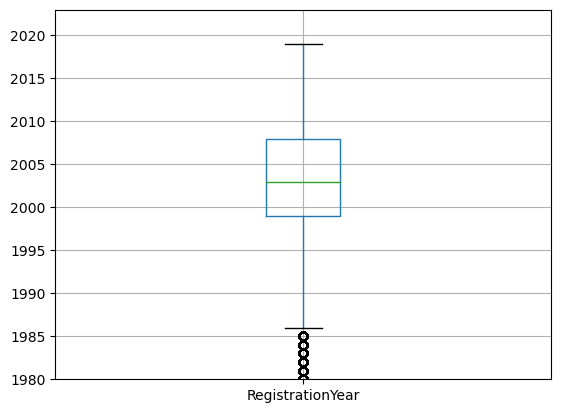

In [13]:
plt.ylim(1980, 2023)
print(data[['RegistrationYear']].boxplot())

In [14]:
data=data.query('RegistrationYear>1980 | RegistrationYear<2024')

Избавившись от аномальных значениям в столбце RegistrationYear, ушел 1% записей, это не много. 

<AxesSubplot:>

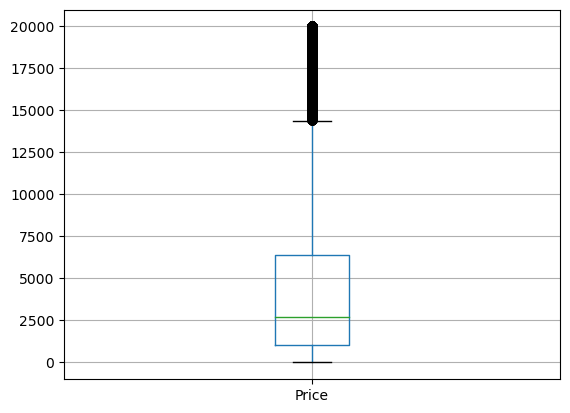

In [15]:
data[['Price']].boxplot()


In [16]:
data=data.query('Price<14500')

Примерно 1% записей ушел при удалении аномалий в столбце Price

AxesSubplot(0.125,0.11;0.775x0.77)


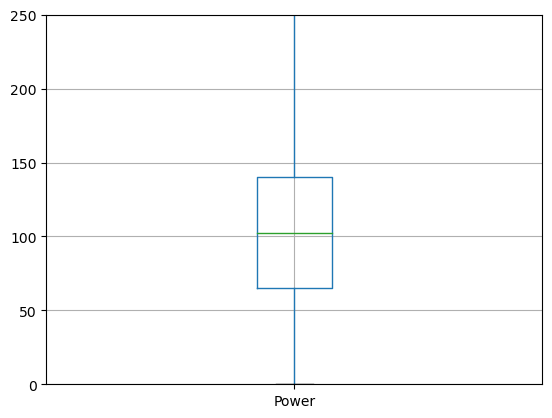

In [17]:
plt.ylim(0, 250)
print(data[['Power']].boxplot())

AxesSubplot(0.125,0.11;0.775x0.77)


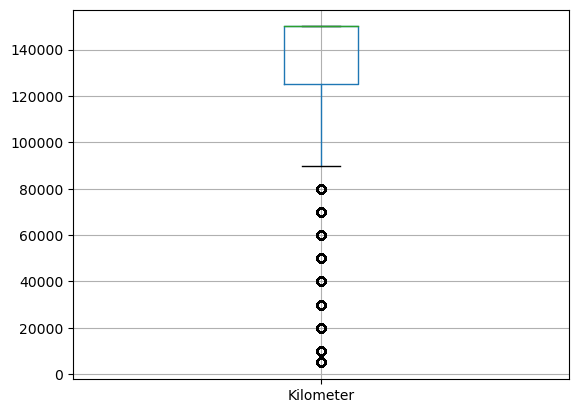

In [18]:
print(data[['Kilometer']].boxplot())

Малый киллометраж нельзя считать ошибкой в данных, поэтому оставлю как есть. 

In [19]:
data_new=data.copy()

In [20]:
features = data.drop('Price', axis=1)
target = data['Price']

In [21]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

Масштабирование количественных признаков

In [22]:
numeric=['RegistrationYear','Power','Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 

Кодирование категориальных признаков

In [23]:
categor = list(set(features_train) - set(numeric))
print(categor)

['Model', 'FuelType', 'Brand', 'VehicleType', 'Gearbox', 'Repaired']


In [24]:
enc = OrdinalEncoder()
enc.fit(features_train[categor])

features_train[categor] = enc.transform(features_train[categor])
features_valid[categor] = enc.transform(features_valid[categor])
features_test[categor] = enc.transform(features_test[categor])


## Стохастический градиентный спуск

In [25]:
start = time.time()
model= make_pipeline(StandardScaler(), SGDRegressor(max_iter=2000))
model.fit(features_train, target_train)
end = time.time()
SGD_fit_time = end - start

In [26]:
start = time.time()
predicted_valid = model.predict(features_valid)
end = time.time()
SGD_predict_time= end - start

In [27]:
mse = mean_squared_error(target_valid, predicted_valid)
print("SGDRegressor")
print("RMSE =", round(mse ** 0.5,2))
SGD_RMSE=round(mse ** 0.5,2)

SGDRegressor
RMSE = 2887.65


## Градиентный бустинг с библиотекой CatBoost

In [28]:
features = data_new.drop('Price', axis=1)
target = data_new['Price']
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [29]:

model = CatBoostRegressor (iterations=300,loss_function='RMSE',learning_rate = 0.99,depth=2,random_seed=12345)


In [30]:
start = time.time()
model.fit(features_train, target_train, cat_features=categor, verbose=20, plot=True)
end = time.time()
CatBoost_fit_time= end - start

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2671.2905755	total: 291ms	remaining: 1m 26s
20:	learn: 1806.5571283	total: 1.91s	remaining: 25.4s
40:	learn: 1731.7408368	total: 3.32s	remaining: 21s
60:	learn: 1693.1375110	total: 4.68s	remaining: 18.3s
80:	learn: 1666.9412922	total: 6.06s	remaining: 16.4s
100:	learn: 1650.5083181	total: 7.51s	remaining: 14.8s
120:	learn: 1639.1304844	total: 8.93s	remaining: 13.2s
140:	learn: 1630.8577267	total: 10.4s	remaining: 11.7s
160:	learn: 1623.3983177	total: 11.8s	remaining: 10.2s
180:	learn: 1613.9177836	total: 13.1s	remaining: 8.61s
200:	learn: 1606.3097584	total: 14.4s	remaining: 7.1s
220:	learn: 1599.9847551	total: 15.9s	remaining: 5.68s
240:	learn: 1594.7026314	total: 17.2s	remaining: 4.2s
260:	learn: 1590.9641573	total: 18.4s	remaining: 2.75s
280:	learn: 1587.3306315	total: 19.6s	remaining: 1.33s
299:	learn: 1584.4388457	total: 21s	remaining: 0us


In [31]:
start = time.time()
predicted_valid = model.predict(features_valid)
end = time.time()
CatBoost_predict_time = end - start

In [32]:
mse = mean_squared_error(target_valid, predicted_valid)
print("CatBoostRegressor")
print("RMSE =", round(mse ** 0.5,2))
CatBoost_RMSE=round(mse ** 0.5,2)

CatBoostRegressor
RMSE = 1575.43


## Градиентный бустинг с библиотекой LightGBM 

In [33]:

features_train[categor] = features_train[categor].astype("category")
features_valid[categor] = features_valid[categor].astype("category")
features_test[categor] = features_test[categor].astype("category")

In [34]:
start = time.time()
model = LGBMRegressor(max_depth=20)
model.fit(features_train, target_train)
end= time.time()
LGBM_fit_time=end-start

In [35]:
start = time.time()
predicted_valid = model.predict(features_valid)
end = time.time()
LGBM_predict_time=end-start

In [36]:
mse = mean_squared_error(target_valid, predicted_valid)
print("LGBMRegressor")
print("RMSE =", round(mse ** 0.5,2))
LGBM_RMSE=round(mse ** 0.5,2)

LGBMRegressor
RMSE = 1477.73


In [37]:
stat=pd.DataFrame(data=[[SGD_fit_time,SGD_predict_time,SGD_RMSE],[CatBoost_fit_time,CatBoost_predict_time,CatBoost_RMSE],[LGBM_fit_time,LGBM_predict_time,LGBM_RMSE]], 
                  index=['SGDRegressor','CatBoostRegressor','LGBMRegressor'],
                  columns=['fit_time','predict_time','RMSE']) 

In [38]:
stat['RMSE']=stat['RMSE']/500

<AxesSubplot:>

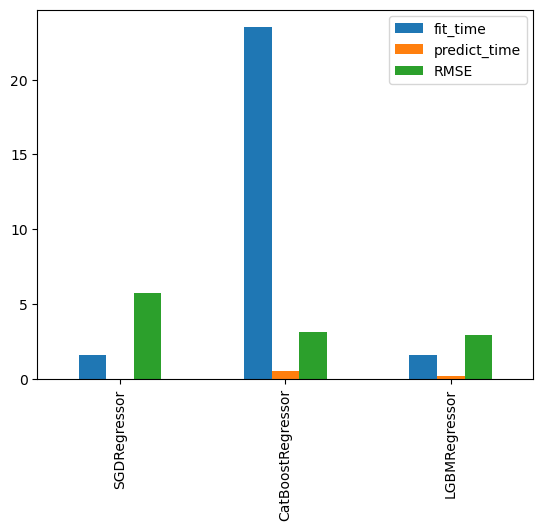

In [39]:
stat.plot.bar()

In [40]:
stat

,fit_time,predict_time,RMSE
SGDRegressor,1.611028,0.034973,5.77530
CatBoostRegressor,23.498792,0.538050,3.15086
LGBMRegressor,1.597953,0.230629,2.95546


## Анализ моделей

## Тестирование лучшей модели

По критерию скорости обучения и предсказания и по величине метрики RSME, можно сделать вывод, что лучшая модель LGBMRegressor.
Протестируем ее на тестовой выборке.

In [41]:
predicted_test = model.predict(features_test)

In [42]:
mse = mean_squared_error(target_test, predicted_test)
print("LGBMRegressor")
print("Test")
print("RMSE =", round(mse ** 0.5,2))

LGBMRegressor
Test
RMSE = 1494.58


На тестовой выборке качество предсказания не сильно упало. 

Вывод:  
В результате сравнительного анализа 3 моделей, я пришла к выводу,  
что модель LGBMRegressor из библиотеки LightGBM в данном случае является наилучшей по трем критерияем оценки.  
качество предсказания - метрика RMSE = 1494.58  
время обучения модели - 2 секунды    
время предсказания модели - 0.3 секунды    
